<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2021/22 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import random
import sys
import re
from string import punctuation
import numpy as np
import pandas as pd
import seaborn as sn

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [2]:
raw_text = open("holmes.txt").read()
raw_text

'ï»¿THE ADVENTURES OF SHERLOCK HOLMES by SIR ARTHUR CONAN DOYLE\n\n   I. A Scandal in Bohemia\n  II. The Red-headed League\n III. A Case of Identity\n  IV. The Boscombe Valley Mystery\n   V. The Five Orange Pips\n  VI. The Man with the Twisted Lip\n VII. The Adventure of the Blue Carbuncle\nVIII. The Adventure of the Speckled Band\n  IX. The Adventure of the Engineer\'s Thumb\n   X. The Adventure of the Noble Bachelor\n  XI. The Adventure of the Beryl Coronet\n XII. The Adventure of the Copper Beeches\n\n\nADVENTURE I. A SCANDAL IN BOHEMIA\n\nI.\n\nTo Sherlock Holmes she is always THE woman. I have seldom heard\nhim mention her under any other name. In his eyes she eclipses\nand predominates the whole of her sex. It was not that he felt\nany emotion akin to love for Irene Adler. All emotions, and that\none particularly, were abhorrent to his cold, precise but\nadmirably balanced mind. He was, I take it, the most perfect\nreasoning and observing machine that the world has seen, but as a

In [3]:
print('Corpus length:', len(raw_text))

Corpus length: 562439


In [4]:
raw_chars = sorted(list(set(raw_text)))
print('Unique characters:', len(raw_chars))
print(raw_chars)

Unique characters: 85
['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '¢', '¨', '©', '»', '¿', 'Ã', 'ï']


### 1.2 Data Processing


In [5]:
def clean(text):
    text = text.lower()
    text = re.sub('\n', ' ', text)
    punctuation = ['!', ',', '.', ':', ';', '?',
                   '-', "'", '"', ' ', '/', '&',
                   '(', ")"]
    letters='abcdefghijklmnopqrstuvwxyz'
    digits='0123456789'
    cleanedTextList =[]
    # Enter your code here:
    for i in text:
        for j in letters:
            if i == j:
                cleanedTextList.append(i)       
                
        for k in punctuation:
            if i == k:
                cleanedTextList.append(i)
                
        for l in digits:
            if i == l:
                cleanedTextList.append(i)
                
    text = ''.join(cleanedTextList)
    text = ' '.join(text.split())
    return text

In [6]:
cleansed_text = clean(raw_text)
cleansed_text

'the adventures of sherlock holmes by sir arthur conan doyle i. a scandal in bohemia ii. the red-headed league iii. a case of identity iv. the boscombe valley mystery v. the five orange pips vi. the man with the twisted lip vii. the adventure of the blue carbuncle viii. the adventure of the speckled band ix. the adventure of the engineer\'s thumb x. the adventure of the noble bachelor xi. the adventure of the beryl coronet xii. the adventure of the copper beeches adventure i. a scandal in bohemia i. to sherlock holmes she is always the woman. i have seldom heard him mention her under any other name. in his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position.

In [7]:
chars = sorted(list(set(cleansed_text)))
print(chars)

[' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
print('Corpus (Cleansed) length:', len(cleansed_text))
print('Unique characters:', len(chars))

Corpus (Cleansed) length: 559572
Unique characters: 50


In [9]:
# Length of extracted character sequences
maxlen = 200

# We sample a new sequence every `step` characters
step = 1

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(cleansed_text) - maxlen, step):
    sentences.append(cleansed_text[i: i + maxlen])
    next_chars.append(cleansed_text[i + maxlen])
print('Number of sequences:', len(sentences))

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 559372


## Step 2 – Develop Character Generator Model

In [10]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

In [16]:
generator = Sequential([
    GRU(5, input_shape=(maxlen, len(chars))),
    Dense(len(chars), activation='softmax')
])
generator.summary()

optimizer = optimizers.RMSprop()
generator.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 855       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                300       
Total params: 1,155
Trainable params: 1,155
Non-trainable params: 0
_________________________________________________________________


In [17]:
acc = []
val_acc = []
loss = []
val_loss = []

for epoch in range(1, 21):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = generator.fit(X, y,
              batch_size=512,
              epochs=1,
              validation_split=0.2)
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    if (epoch%10==0):
        # Select a text seed at random
        start_index = random.randint(0, len(cleansed_text) - maxlen - 1)
        generated_text_initial = cleansed_text[start_index: start_index + maxlen]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 0.8]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(401):
                sampled = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = generator.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

epoch 1
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 22s 49us/sample - loss: 3.0900 - acc: 0.1570 - val_loss: 2.8082 - val_acc: 0.2033
epoch 2
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 18s 41us/sample - loss: 2.6311 - acc: 0.2596 - val_loss: 2.4974 - val_acc: 0.2772
epoch 3
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 18s 40us/sample - loss: 2.4501 - acc: 0.2891 - val_loss: 2.3923 - val_acc: 0.3121
epoch 4
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 18s 40us/sample - loss: 2.3725 - acc: 0.3139 - val_loss: 2.3384 - val_acc: 0.3195
epoch 5
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 18s 40us/sample - loss: 2.3318 - acc: 0.3240 - val_loss: 2.3090 - val_acc: 0.3281
epoch 6
Train on 447497 samples, validate on 

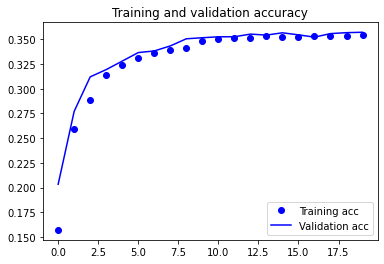

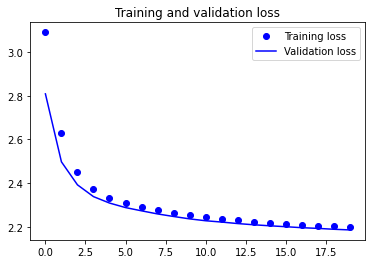

In [18]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
generator = Sequential([
    GRU(len(chars), input_shape=(maxlen, len(chars))),
    Dense(len(chars), activation='softmax')
])
generator.summary()

optimizer = optimizers.RMSprop()
generator.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
Total params: 17,850
Trainable params: 17,850
Non-trainable params: 0
_________________________________________________________________


In [23]:
acc = []
val_acc = []
loss = []
val_loss = []

for epoch in range(1, 21):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = generator.fit(X, y,
              batch_size=512,
              epochs=1,
              validation_split=0.2)
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    if (epoch%10==0):
        # Select a text seed at random
        start_index = random.randint(0, len(cleansed_text) - maxlen - 1)
        generated_text_initial = cleansed_text[start_index: start_index + maxlen]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 0.8]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(401):
                sampled = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = generator.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

epoch 1
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 24s 54us/sample - loss: 2.4527 - acc: 0.3026 - val_loss: 2.1707 - val_acc: 0.3647
epoch 2
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 22s 49us/sample - loss: 2.0612 - acc: 0.3903 - val_loss: 1.9815 - val_acc: 0.4082
epoch 3
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 23s 51us/sample - loss: 1.9306 - acc: 0.4249 - val_loss: 1.8768 - val_acc: 0.4403
epoch 4
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 23s 52us/sample - loss: 1.8519 - acc: 0.4471 - val_loss: 1.8180 - val_acc: 0.4565
epoch 5
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 22s 49us/sample - loss: 1.7994 - acc: 0.4615 - val_loss: 1.7742 - val_acc: 0.4683
epoch 6
Train on 447497 samples, validate on 

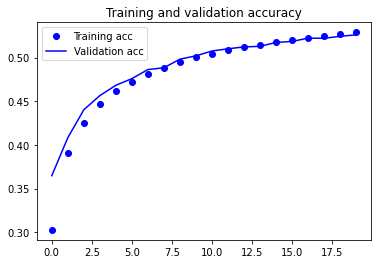

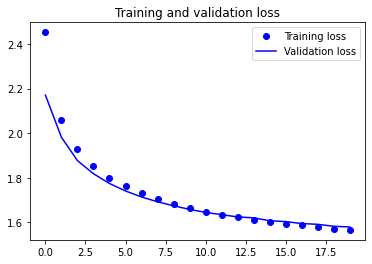

In [24]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
generator = Sequential([
    GRU(5*len(chars), input_shape=(maxlen, len(chars))),
    Dense(len(chars), activation='softmax')
])
generator.summary()

optimizer = optimizers.RMSprop()
generator.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 250)               226500    
_________________________________________________________________
dense (Dense)                (None, 50)                12550     
Total params: 239,050
Trainable params: 239,050
Non-trainable params: 0
_________________________________________________________________


In [12]:
acc = []
val_acc = []
loss = []
val_loss = []

for epoch in range(1, 31):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = generator.fit(X, y,
              batch_size=512,
              epochs=1,
              validation_split=0.2)
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    if (epoch%15==0):
        # Select a text seed at random
        start_index = random.randint(0, len(cleansed_text) - maxlen - 1)
        generated_text_initial = cleansed_text[start_index: start_index + maxlen]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 0.8]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(401):
                sampled = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = generator.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

epoch 1
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 50s 112us/sample - loss: 2.2008 - acc: 0.3636 - val_loss: 1.9474 - val_acc: 0.4203
epoch 2
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.7874 - acc: 0.4649 - val_loss: 1.7574 - val_acc: 0.4724
epoch 3
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 47s 105us/sample - loss: 1.6282 - acc: 0.5101 - val_loss: 1.6017 - val_acc: 0.5162
epoch 4
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.5232 - acc: 0.5398 - val_loss: 1.5475 - val_acc: 0.5358
epoch 5
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.4463 - acc: 0.5613 - val_loss: 1.4914 - val_acc: 0.5451
epoch 6
Train on 447497 samples, validat

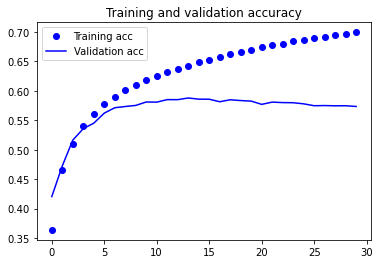

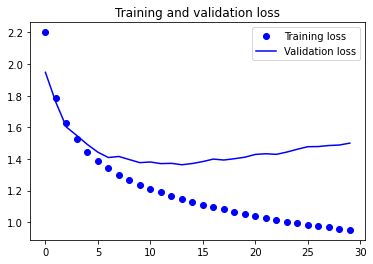

In [13]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
generator = Sequential([
    GRU(5*len(chars), kernel_regularizer=regularizers.l2(0.01),input_shape=(maxlen, len(chars))),
    Dense(len(chars), activation='softmax')
])
generator.summary()

optimizer = optimizers.RMSprop()
generator.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 250)               226500    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12550     
Total params: 239,050
Trainable params: 239,050
Non-trainable params: 0
_________________________________________________________________


In [15]:
acc = []
val_acc = []
loss = []
val_loss = []

for epoch in range(1, 31):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = generator.fit(X, y,
              batch_size=512,
              epochs=1,
              validation_split=0.2)
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    if (epoch%15==0):
        # Select a text seed at random
        start_index = random.randint(0, len(cleansed_text) - maxlen - 1)
        generated_text_initial = cleansed_text[start_index: start_index + maxlen]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 0.8]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(401):
                sampled = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = generator.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

epoch 1
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 48s 108us/sample - loss: 2.5410 - acc: 0.3086 - val_loss: 2.3783 - val_acc: 0.3400
epoch 2
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 2.2328 - acc: 0.3803 - val_loss: 2.2370 - val_acc: 0.3714
epoch 3
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 2.1172 - acc: 0.4092 - val_loss: 2.1135 - val_acc: 0.4091
epoch 4
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 2.0363 - acc: 0.4293 - val_loss: 2.0492 - val_acc: 0.4206
epoch 5
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.9729 - acc: 0.4463 - val_loss: 1.9990 - val_acc: 0.4411
epoch 6
Train on 447497 samples, validat

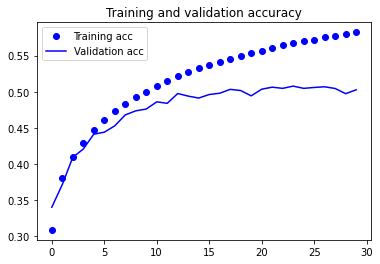

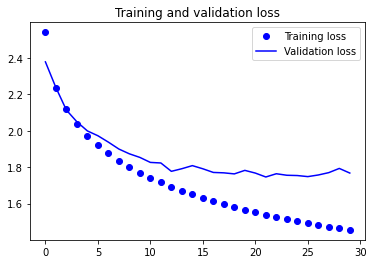

In [16]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
generator = Sequential([
    GRU(5*len(chars), input_shape=(maxlen, len(chars))),
    Dense(len(chars), activation='softmax')
])
generator.summary()

optimizer = optimizers.Adam()
generator.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 250)               226500    
_________________________________________________________________
dense (Dense)                (None, 50)                12550     
Total params: 239,050
Trainable params: 239,050
Non-trainable params: 0
_________________________________________________________________


In [12]:
acc = []
val_acc = []
loss = []
val_loss = []

for epoch in range(1, 31):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = generator.fit(X, y,
              batch_size=512,
              epochs=1,
              validation_split=0.2)
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    if (epoch%15==0):
        # Select a text seed at random
        start_index = random.randint(0, len(cleansed_text) - maxlen - 1)
        generated_text_initial = cleansed_text[start_index: start_index + maxlen]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 0.8]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(401):
                sampled = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = generator.predict(sampled, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

epoch 1
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 51s 114us/sample - loss: 2.2285 - acc: 0.3556 - val_loss: 1.9121 - val_acc: 0.4332
epoch 2
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.7958 - acc: 0.4623 - val_loss: 1.6829 - val_acc: 0.4934
epoch 3
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.6166 - acc: 0.5116 - val_loss: 1.5663 - val_acc: 0.5278
epoch 4
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.5041 - acc: 0.5443 - val_loss: 1.4875 - val_acc: 0.5477
epoch 5
Train on 447497 samples, validate on 111875 samples
447497/447497 [==============================] - 46s 103us/sample - loss: 1.4246 - acc: 0.5668 - val_loss: 1.4398 - val_acc: 0.5628
epoch 6
Train on 447497 samples, validat

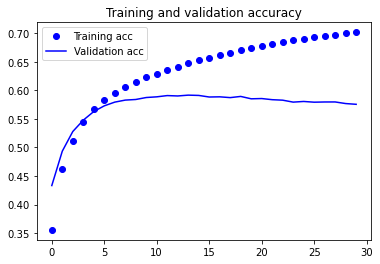

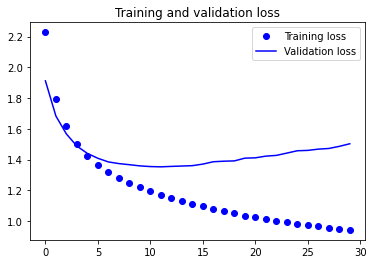

In [13]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
generator = Sequential([
    GRU(5*len(chars), input_shape=(maxlen, len(chars))),
    Dense(len(chars), activation='softmax')
])
generator.summary()

optimizer = optimizers.Adam()
generator.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 250)               226500    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12550     
Total params: 239,050
Trainable params: 239,050
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = generator.fit(X, y,
              batch_size=512,
              epochs=8,
              validation_split=0.2)

Train on 447497 samples, validate on 111875 samples
Epoch 1/8
447497/447497 [==============================] - 48s 107us/sample - loss: 2.2636 - acc: 0.3472 - val_loss: 1.9431 - val_acc: 0.4199
Epoch 2/8
447497/447497 [==============================] - 46s 103us/sample - loss: 1.8119 - acc: 0.4584 - val_loss: 1.7003 - val_acc: 0.4867
Epoch 3/8
447497/447497 [==============================] - 46s 104us/sample - loss: 1.6281 - acc: 0.5093 - val_loss: 1.5655 - val_acc: 0.5261
Epoch 4/8
447497/447497 [==============================] - 46s 103us/sample - loss: 1.5106 - acc: 0.5434 - val_loss: 1.4905 - val_acc: 0.5465
Epoch 5/8
447497/447497 [==============================] - 46s 103us/sample - loss: 1.4282 - acc: 0.5664 - val_loss: 1.4418 - val_acc: 0.5625
Epoch 6/8
447497/447497 [==============================] - 46s 103us/sample - loss: 1.3672 - acc: 0.5833 - val_loss: 1.4100 - val_acc: 0.5693
Epoch 7/8
447497/447497 [==============================] - 46s 103us/sample - loss: 1.3192 - acc

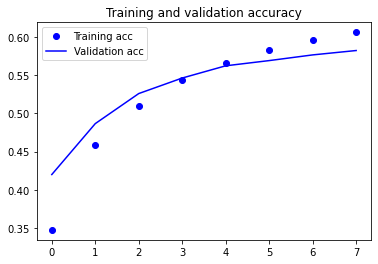

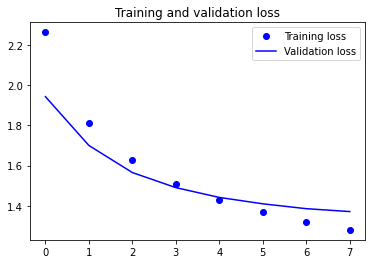

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
start_index = random.randint(0, len(cleansed_text) - maxlen - 1)
generated_text_initial = cleansed_text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.2, 0.3, 0.4, 0.5]:
    generated_text = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(401):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = generator.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

--- Generating with seed: "ing. then he suddenly rolled them all into a gigantic ball and tossed them up onto the rack. "have you heard anything of the case?" he asked. "not a word. i have not seen a paper for some days." "the "
------ temperature: 0.2
ing. then he suddenly rolled them all into a gigantic ball and tossed them up onto the rack. "have you heard anything of the case?" he asked. "not a word. i have not seen a paper for some days." "the first to come to the facts and the state of the street. i have not a common like that i have not have a strange that i have some strange that i have had the bark against the bark and that i have not the body was sure that the station is a recold bed that i have some strange that i have not a common like a case in the lady street, and that i have not a case of the facts and the man who was a strange
------ temperature: 0.3
ing. then he suddenly rolled them all into a gigantic ball and tossed them up onto the rack. "have you heard anything of 

In [18]:
generator.save('CharGenerator.h5')

## Step 3 – Use the developed Model to generate the characters / sentences

In [11]:
generator = models.load_model('CharGenerator.h5')

In [43]:
# takes the user input
text_input = clean(input())

A wonderful serenity has taken possession of my entire soul, like these sweet mornings of spring which I enjoy with my whole heart. I am alone, and feel the charm of existence in this spot, which was.


In [45]:
# encode the user input
maxlen = 200
step = 1
sentences = []
next_chars = []
for i in range(0, len(text_input) - maxlen, step):
    sentences.append(text_input[i: i + maxlen])
    next_chars.append(text_input[i + maxlen])

X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [46]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

In [47]:
# Use the Best Model to generate 400 characters
print("----- Generating Text with final model-----")
print('----- Generating with seed: "' + text_input + '" -----')

for temperature in [0.2, 0.3, 0.4, 0.5]:
    print()
    print('----- temperature: '+ str(temperature) + ' -----')
    generated = text_input
    sys.stdout.write(generated)
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated):
            sampled[0, t, char_indices[char]] = 1.

        preds = generator.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated += next_char
        generated = generated[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    

----- Generating Text with final model-----
----- Generating with seed: "a wonderful serenity has taken possession of my entire soul, like these sweet mornings of spring which i enjoy with my whole heart. i am alone, and feel the charm of existence in this spot, which was." -----

----- temperature: 0.2 -----
a wonderful serenity has taken possession of my entire soul, like these sweet mornings of spring which i enjoy with my whole heart. i am alone, and feel the charm of existence in this spot, which was. i was a little propose more than the street, and the station of the man who was a words which had been to be the bark and the forther sat a man who is a street. the station is a man who is a strange than that the statement which had been the last had been a man who had been and some the man who is a strange that the bad and that the stanting of the state of the case which was some strange that th

----- temperature: 0.3 -----
a wonderful serenity has taken possession of my entire sou